In [7]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the CSV files
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Step 2: Merge data
# Merge transactions with customer information
merged_data = pd.merge(transactions, customers, on='CustomerID', how='inner')

merged_data = merged_data.drop(columns='ProductID')


In [8]:
merged_data

,TransactionID,CustomerID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15
...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,2024-10-24 08:30:27,1,459.86,459.86,Jacob Holt,South America,2022-01-22
996,T00759,C0059,2024-06-04 02:15:24,3,1379.58,459.86,Mrs. Kimberly Wright,North America,2024-04-07
997,T00922,C0018,2024-04-05 13:05:32,4,1839.44,459.86,Tyler Haynes,North America,2024-09-21
998,T00959,C0115,2024-09-29 10:16:02,2,919.72,459.86,Joshua Hamilton,Asia,2024-11-11


In [11]:
# Step 3: Feature Engineering
# Calculate total spent by each customer
customer_total_spent = merged_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
customer_total_spent.columns = ['CustomerID', 'TotalSpent']

# Calculate the average cart value by each customer
customer_avg_cart_value = merged_data.groupby('CustomerID')['TotalValue'].mean().reset_index()
customer_avg_cart_value.columns = ['CustomerID', 'AvgCartValue']

# Calculate the number of transactions by each customer (purchase frequency)
customer_frequency = merged_data.groupby('CustomerID')['TransactionID'].nunique().reset_index()
customer_frequency.columns = ['CustomerID', 'PurchaseFrequency']

customer_features = pd.merge(customer_total_spent, customer_avg_cart_value, on='CustomerID')
customer_features = pd.merge(customer_features, customer_frequency, on='CustomerID')


In [14]:
customer_features

,CustomerID,TotalSpent,AvgCartValue,PurchaseFrequency
0,C0001,3354.52,670.904000,5
1,C0002,1862.74,465.685000,4
2,C0003,2725.38,681.345000,4
3,C0004,5354.88,669.360000,8
4,C0005,2034.24,678.080000,3
...,...,...,...,...
194,C0196,4982.88,1245.720000,4
195,C0197,1928.65,642.883333,3
196,C0198,931.83,465.915000,2
197,C0199,1979.28,494.820000,4


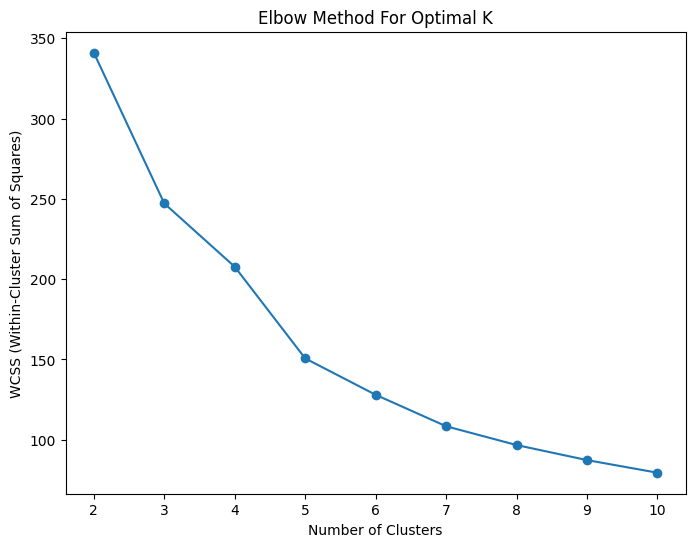

In [16]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['TotalSpent', 'AvgCartValue', 'PurchaseFrequency']])

# Step 2: Elbow Method to find the optimal number of clusters
wcss = []  # List to store WCSS for each K
for k in range(2, 11):  # Testing from 2 to 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

# Plotting Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()


Davies-Bouldin Index: 0.8524813520458038
Silhouette Score: 0.3535127066812944
Calinski-Harabasz Score: 143.70464826443802


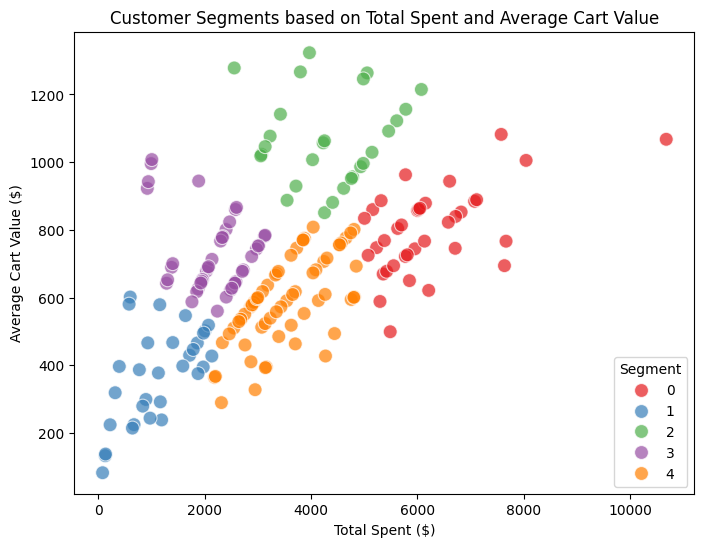

In [26]:
from sklearn.metrics import davies_bouldin_score

optimal_k = 5

# Step 4: Perform K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Segment'] = kmeans.fit_predict(scaled_features)

# Step 5: Calculate Davies-Bouldin Index and other metrics
db_index = davies_bouldin_score(scaled_features, customer_features['Segment'])
print(f'Davies-Bouldin Index: {db_index}')

# Additional metrics (e.g., silhouette score, calinski harabasz score) can also be calculated
from sklearn.metrics import silhouette_score, calinski_harabasz_score

sil_score = silhouette_score(scaled_features, customer_features['Segment'])
calinski_score = calinski_harabasz_score(scaled_features, customer_features['Segment'])

print(f'Silhouette Score: {sil_score}')
print(f'Calinski-Harabasz Score: {calinski_score}')

# Step 6: Visualizing the Clusters (2D scatter plot for better visualization)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_features['TotalSpent'], y=customer_features['AvgCartValue'], hue=customer_features['Segment'], palette='Set1', s=100, alpha=0.7)
plt.title('Customer Segments based on Total Spent and Average Cart Value')
plt.xlabel('Total Spent ($)')
plt.ylabel('Average Cart Value ($)')
plt.legend(title='Segment')
plt.show()

Agglomerative Davies-Bouldin Index: 0.8851081906022241

Additional Metrics:
Agglomerative Silhouette Score: 0.34265137202494406
Agglomerative Calinski-Harabasz Score: 130.61439024040507


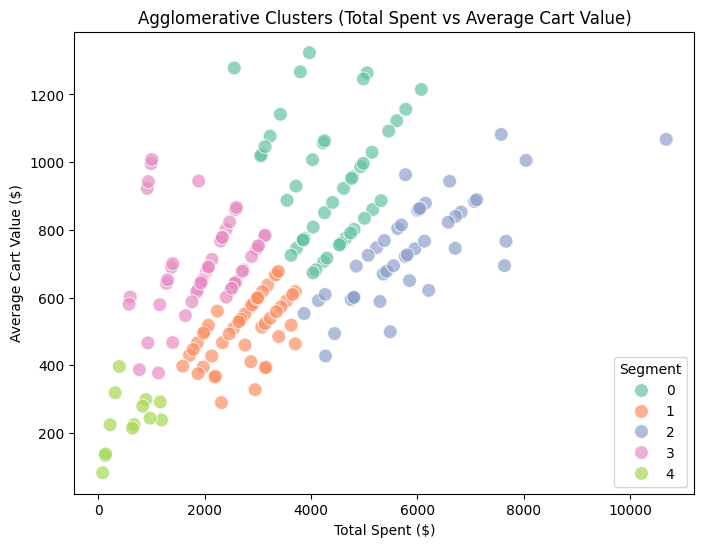

In [34]:
# Step 2: Perform K-Means Clustering (K=4 as chosen from previous code)
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Step 3: Perform Agglomerative Hierarchical Clustering (using ward linkage)
agg_clust = AgglomerativeClustering(n_clusters=5, linkage='ward')
customer_features['Agglomerative_Segment'] = agg_clust.fit_predict(scaled_features)

agg_db = davies_bouldin_score(scaled_features, customer_features['Agglomerative_Segment'])

print(f"Agglomerative Davies-Bouldin Index: {agg_db}")

# Additional metrics (Silhouette Score and Calinski-Harabasz Score)
print("\nAdditional Metrics:")
print(f"Agglomerative Silhouette Score: {silhouette_score(scaled_features, customer_features['Agglomerative_Segment'])}")

print(f"Agglomerative Calinski-Harabasz Score: {calinski_harabasz_score(scaled_features, customer_features['Agglomerative_Segment'])}")


# Agglomerative Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_features['TotalSpent'], y=customer_features['AvgCartValue'], hue=customer_features['Agglomerative_Segment'], palette='Set2', s=100, alpha=0.7)
plt.title('Agglomerative Clusters (Total Spent vs Average Cart Value)')
plt.xlabel('Total Spent ($)')
plt.ylabel('Average Cart Value ($)')
plt.legend(title='Segment')
plt.show()


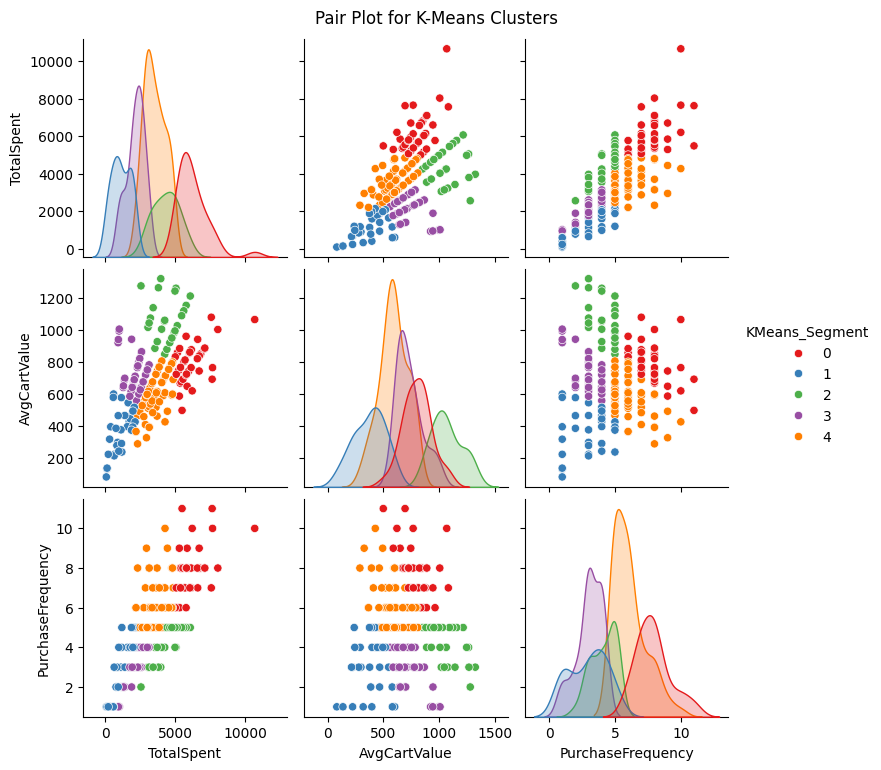

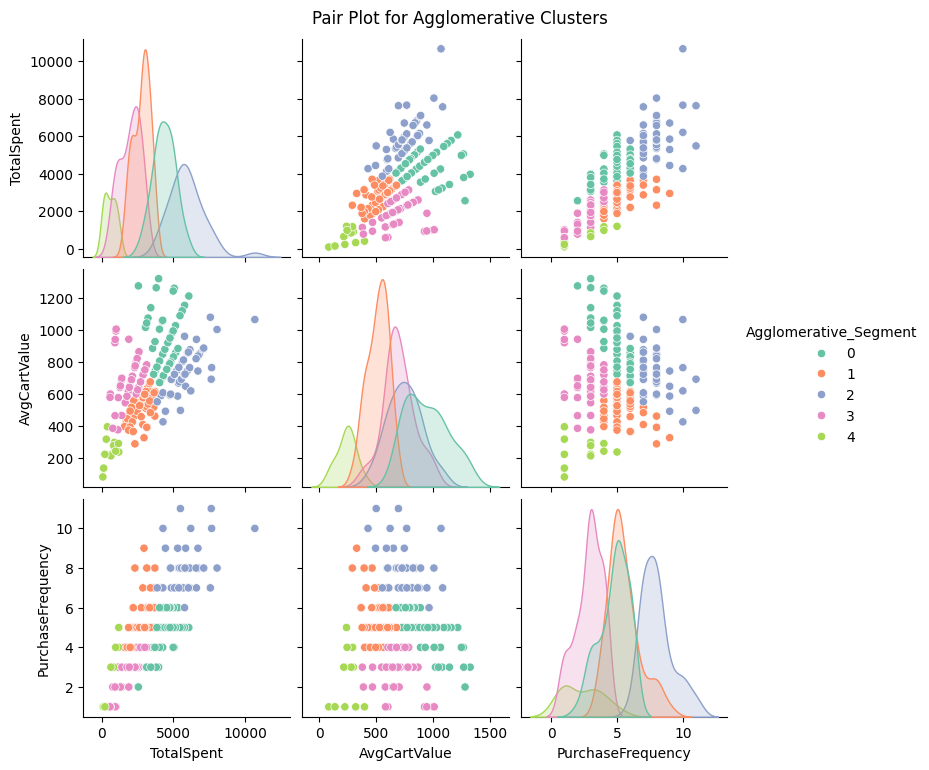

In [35]:
sns.pairplot(customer_features[['TotalSpent', 'AvgCartValue', 'PurchaseFrequency', 'KMeans_Segment']], 
             hue='KMeans_Segment', palette='Set1', diag_kind='kde')
plt.suptitle('Pair Plot for K-Means Clusters', y=1.02)
plt.show()

# 4. Pair Plot for Agglomerative Clusters
sns.pairplot(customer_features[['TotalSpent', 'AvgCartValue', 'PurchaseFrequency', 'Agglomerative_Segment']], 
             hue='Agglomerative_Segment', palette='Set2', diag_kind='kde')
plt.suptitle('Pair Plot for Agglomerative Clusters', y=1.02)
plt.show()